In [1]:
%reload_ext watermark
%watermark -v -m -p numpy,matplotlib,sklearn,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 9.0.2

numpy       : 2.2.3
matplotlib  : 3.10.1
sklearn     : 1.6.1
pandas      : 2.2.3
torch       : 2.6.0
transformers: 4.49.0

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 3, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Load Data

In [3]:
# load data
train_df = pd.read_csv('data/train_split.tsv', sep='\t')
test_df = pd.read_csv('data/test.tsv', sep='\t', header=None, names=['text', 'label'])
val_df = pd.read_csv('data/val_split.tsv', sep='\t')

# test_df.head()
train_df.head()

,text,label
0,graphic sex may be what 's attracting audience...,1
1,perhaps the grossest movie ever made,0
2,"the film is moody , oozing , chilling and hear...",1
3,watching the chemistry between freeman and jud...,1
4,the wonderfully lush morvern callar is pure pu...,1


In [4]:
imdb_train_df = pd.read_csv('data/train_imdb_split.csv')
imdb_val_df = pd.read_csv('data/val_imdb_split.csv')
imdb_test_df = pd.read_csv('data/test_imdb_split.csv')

imdb_train_df.head()

,text,label
0,With no fault to the actors (they all put on g...,0
1,The first thing I thought when I saw this film...,1
2,Post-feminist depiction of cruelty and sadism....,1
3,OMG this is one of the worst films iv ever see...,0
4,"The Box is a film with great potential, but th...",0


### Model

In [5]:
import torch
import torch.nn as nn

class MLP_Model(nn.Module):
    def __init__(self, input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3):
        super(MLP_Model, self).__init__()

        self.layers = nn.ModuleDict({
            "Layer 1": nn.Sequential(
                nn.Linear(input_size, hidden_sizes[0]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 2": nn.Sequential(
                nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 3": nn.Sequential(
                nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 4": nn.Sequential(
                nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 5": nn.Linear(hidden_sizes[3], output_size)
        })

    def forward(self, x):
        for name, layer in self.layers.items():
            x = layer(x)
        return x

model = MLP_Model()
print(model)

MLP_Model(
  (layers): ModuleDict(
    (Layer 1): Sequential(
      (0): Linear(in_features=10000, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 4): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 5): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [6]:
sum_params = 0

for name, param in model.named_parameters():
    print(f'Layer: {name} | Size: {param.size()} | Params: {param.numel()} | Trainable: {param.requires_grad}')
    if param.requires_grad:
        sum_params += param.numel()

print(f'Total Trainable Parameters: {sum_params}')

Layer: layers.Layer 1.0.weight | Size: torch.Size([512, 10000]) | Params: 5120000 | Trainable: True
Layer: layers.Layer 1.0.bias | Size: torch.Size([512]) | Params: 512 | Trainable: True
Layer: layers.Layer 2.0.weight | Size: torch.Size([256, 512]) | Params: 131072 | Trainable: True
Layer: layers.Layer 2.0.bias | Size: torch.Size([256]) | Params: 256 | Trainable: True
Layer: layers.Layer 3.0.weight | Size: torch.Size([128, 256]) | Params: 32768 | Trainable: True
Layer: layers.Layer 3.0.bias | Size: torch.Size([128]) | Params: 128 | Trainable: True
Layer: layers.Layer 4.0.weight | Size: torch.Size([64, 128]) | Params: 8192 | Trainable: True
Layer: layers.Layer 4.0.bias | Size: torch.Size([64]) | Params: 64 | Trainable: True
Layer: layers.Layer 5.weight | Size: torch.Size([2, 64]) | Params: 128 | Trainable: True
Layer: layers.Layer 5.bias | Size: torch.Size([2]) | Params: 2 | Trainable: True
Total Trainable Parameters: 5293122


### Bag-of-words

The bag-of-words model (BoW) is a model of text which uses an unordered collection (a "bag") of words. It disregards word order (and thus most of syntax or grammar) but captures multiplicity.

Each key is the word, and each value is the number of occurrences of that word in the given text document.

```javascript
(1) John likes to watch movies. Mary likes movies too.

(2) Mary also likes to watch football games.
```

Based on these two text documents, a list is constructed as follows for each document:

```javascript
"John","likes","to","watch","movies","Mary","likes","movies","too"

"Mary","also","likes","to","watch","football","games"
```

Representing each bag-of-words as a JSON object, and attributing to the respective JavaScript variable:

```javascript
BoW1 = {"John":1,"likes":2,"to":1,"watch":1,"movies":2,"Mary":1,"too":1};

BoW2 = {"Mary":1,"also":1,"likes":1,"to":1,"watch":1,"football":1,"games":1};
```

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist())
val_dataset = TextDataset(val_df["text"].tolist(), val_df["label"].tolist())
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist())

In [42]:
# Batch size
BATCH_SIZE = 32

# Fit CountVectorizer on training data
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(train_df["text"])

# Collate function for BoW
def bow_collate_fn(batch):
    texts, labels = zip(*batch)  # Unpack batch into texts and labels
    X_batch = vectorizer.transform(texts).toarray()  # Vectorize texts using BoW
    X_batch_tensor = torch.tensor(X_batch, dtype=torch.float32)  # Convert to tensor
    y_batch_tensor = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor (for classification tasks)
    return X_batch_tensor, y_batch_tensor

# Create DataLoaders for BoW
train_loader_bow = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bow_collate_fn)
val_loader_bow = DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle = False, collate_fn=bow_collate_fn)
test_loader_bow = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle= False, collate_fn=bow_collate_fn)

print(f"Number of training batches: {len(train_loader_bow)}")
print(f"Number of validation batches: {len(val_loader_bow)}")
print(f"Number of test batches: {len(test_loader_bow)}")


Number of training batches: 173
Number of validation batches: 44
Number of test batches: 57


In [43]:
import numpy as np

# Map word indices to words
word2idx = vectorizer.vocabulary_
idx2word = {v: k for k, v in word2idx.items()}

sample_number = 5  #  any value within the first batch (e.g., 0, 1, ..., batch_size-1)

# Take a specific sample from the validation DataFrame
val_text_sample = val_df.text.iloc[sample_number]  # Select the sample from validation set
val_label_sample = val_df.label.iloc[sample_number]  # Get the corresponding label
print("Original Sentence:", val_text_sample.split())
print("Original sentence label:", val_label_sample)

# Get the first batch from val_loader_bow
X_batch, y_batch = next(iter(val_loader_bow))  # Get the first batch from DataLoader

# Extract the specific sample from the first batch
X_bow_sample = X_batch[sample_number]
y_bow_sample = y_batch[sample_number]

# Print BoW representation details
print("BoW representation shape:", X_bow_sample.shape)
print("BoW representation:", X_bow_sample)

# Find non-zero indices in the BoW representation
nonzero_indices = torch.nonzero(X_bow_sample).flatten().numpy()  # Non-zero indices correspond to words present in the sentence
print("Non-zero indices:", nonzero_indices)

# Map non-zero indices back to words using idx2word
words_in_sentence = [idx2word[idx] for idx in nonzero_indices]
print("Words in BoW representation:", words_in_sentence)

# Compare with original sentence (sorted)
original_words_sorted = sorted(val_text_sample.split())
print("Original words in sentence (sorted):", original_words_sorted)

# Print lengths for comparison
print("Length of original sentence:", len(original_words_sorted))
print("Length of BoW-represented words:", len(words_in_sentence))


Original Sentence: ['tara', 'reid', 'plays', 'a', 'college', 'journalist', ',', 'but', 'she', 'looks', 'like', 'the', 'six', 'time', 'winner', 'of', 'the', 'miss', 'hawaiian', 'tropic', 'pageant', ',', 'so', 'i', 'do', "n't", 'know', 'what', 'she', "'s", 'doing', 'in', 'here']
Original sentence label: 0
BoW representation shape: torch.Size([10000])
BoW representation: tensor([0., 0., 0.,  ..., 0., 0., 0.])
Non-zero indices: [ 751 1031 1968 1991 3862 3939 4322 4795 4937 5191 5295 5786 6293 6902
 8502 8671 8803 9308 9378 9837 9882]
Words in BoW representation: ['but', 'college', 'do', 'doing', 'hawaiian', 'here', 'in', 'journalist', 'know', 'like', 'looks', 'miss', 'of', 'plays', 'she', 'six', 'so', 'the', 'time', 'what', 'winner']
Original words in sentence (sorted): ["'s", ',', ',', 'a', 'but', 'college', 'do', 'doing', 'hawaiian', 'here', 'i', 'in', 'journalist', 'know', 'like', 'looks', 'miss', "n't", 'of', 'pageant', 'plays', 'reid', 'she', 'she', 'six', 'so', 'tara', 'the', 'the', 

###  Embedding Model bert-base-uncased

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [45]:
from transformers import AutoTokenizer, AutoModel

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer)

bert = AutoModel.from_pretrained(model_name)

embedding_size = bert.config.hidden_size
print('Embedding size:',embedding_size)

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)
Embedding size: 768


In [46]:
bert.eval()
bert.to(device)

text = 'hello world'
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
print(inputs['input_ids'])
print(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))

with torch.no_grad():
    outputs = bert(**inputs.to(device))

embeddings = outputs.last_hidden_state
print('First id:',inputs['input_ids'][0][1])
print('First token:',tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[1])
print('Embedding shape:',embeddings.shape)


sentence_embeddings = torch.mean(embeddings, dim=1)
print('Sentence embedding shape:',sentence_embeddings.shape)

# CLS : first token, SEP : last token

tensor([[ 101, 7592, 2088,  102]])
['[CLS]', 'hello', 'world', '[SEP]']
First id: tensor(7592)
First token: hello
Embedding shape: torch.Size([1, 4, 768])
Sentence embedding shape: torch.Size([1, 768])


In [47]:
def get_bert_embeddings(inputs, bert, pooling_strategy='mean'):
    with torch.no_grad():
        outputs = bert(**inputs)
        
    embeddings = outputs.last_hidden_state
    
    if pooling_strategy == 'mean':
        sentence_embeddings = torch.mean(embeddings, dim=1)  # Mean pooling
    elif pooling_strategy == 'max':
        sentence_embeddings = torch.max(embeddings, dim=1).values  # Max pooling
    elif pooling_strategy == 'cls':
        sentence_embeddings = embeddings[:, 0, :]  # CLS token
    elif pooling_strategy == 'sep':
        sentence_embeddings = embeddings[:, -1, :]  # SEP token
    else:
        raise ValueError("Pooling strategy not valid")

    return sentence_embeddings

# Collate function for dynamic batching and embedding generation
def bert_collate_fn(batch):
    texts = [item[0] for item in batch]  # Extract texts from batch
    labels = None
    if isinstance(batch[0], tuple) and len(batch[0]) > 1:
        labels = torch.tensor([item[1] for item in batch], dtype=torch.long)  # Extract labels if available
    
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    sentence_embeddings = get_bert_embeddings(inputs, bert, pooling_strategy=pooling_strategy)

    return sentence_embeddings.cpu()

BATCH_SIZE = 32
pooling_strategy = 'mean'  

train_loader_bert = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bert_collate_fn)
val_loader_bert = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=bert_collate_fn)
test_loader_bert = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=bert_collate_fn)

print(f"Number of training batches: {len(train_loader_bert)}")
print(f"Number of validation batches: {len(val_loader_bert)}")
print(f"Number of test batches: {len(test_loader_bert)}")

Number of training batches: 173
Number of validation batches: 44
Number of test batches: 57


### Training on Dataset I

In [50]:
import torch
import torch.nn as nn

def train(model, model_path, optimizer, criterion, train_loader, val_loader, num_epochs, device):
    model.to(device)
    best_loss = float('inf')
    train_loss_history = []
    val_loss_history = []
    best_model_state = None

    for epoch in range(1, num_epochs + 1):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)  # Average training loss over all batches

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_pred_val = model(X_batch)
                loss = criterion(y_pred_val, y_batch)
                val_loss += loss.item()

                # Calculate validation accuracy
                y_pred_val_class = torch.argmax(y_pred_val, dim=1)
                correct += torch.sum(y_pred_val_class == y_batch).item()
                total += y_batch.size(0)

        val_loss /= len(val_loader)  # Average validation loss over all batches
        val_acc = correct / total

        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        # Save the best model based on validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()

    # Save the best model to file
    print('best val loss:', best_loss)
    torch.save(best_model_state, model_path)

    return train_loss_history, val_loss_history

#### Training bow model

Epoch: 1 | Train Loss: 0.6921 | Val Loss: 0.6883 | Val Acc: 0.5152
Epoch: 2 | Train Loss: 0.6050 | Val Loss: 0.4961 | Val Acc: 0.7767
Epoch: 3 | Train Loss: 0.3061 | Val Loss: 0.4682 | Val Acc: 0.8064
Epoch: 4 | Train Loss: 0.1430 | Val Loss: 0.5482 | Val Acc: 0.8092
Epoch: 5 | Train Loss: 0.0642 | Val Loss: 0.7200 | Val Acc: 0.7955
Epoch: 6 | Train Loss: 0.0309 | Val Loss: 0.8037 | Val Acc: 0.7941
Epoch: 7 | Train Loss: 0.0184 | Val Loss: 0.8968 | Val Acc: 0.7999
Epoch: 8 | Train Loss: 0.0115 | Val Loss: 0.9665 | Val Acc: 0.8027
Epoch: 9 | Train Loss: 0.0077 | Val Loss: 1.0608 | Val Acc: 0.8056
Epoch: 10 | Train Loss: 0.0040 | Val Loss: 1.1284 | Val Acc: 0.8056
best val loss: 0.4681616984307766


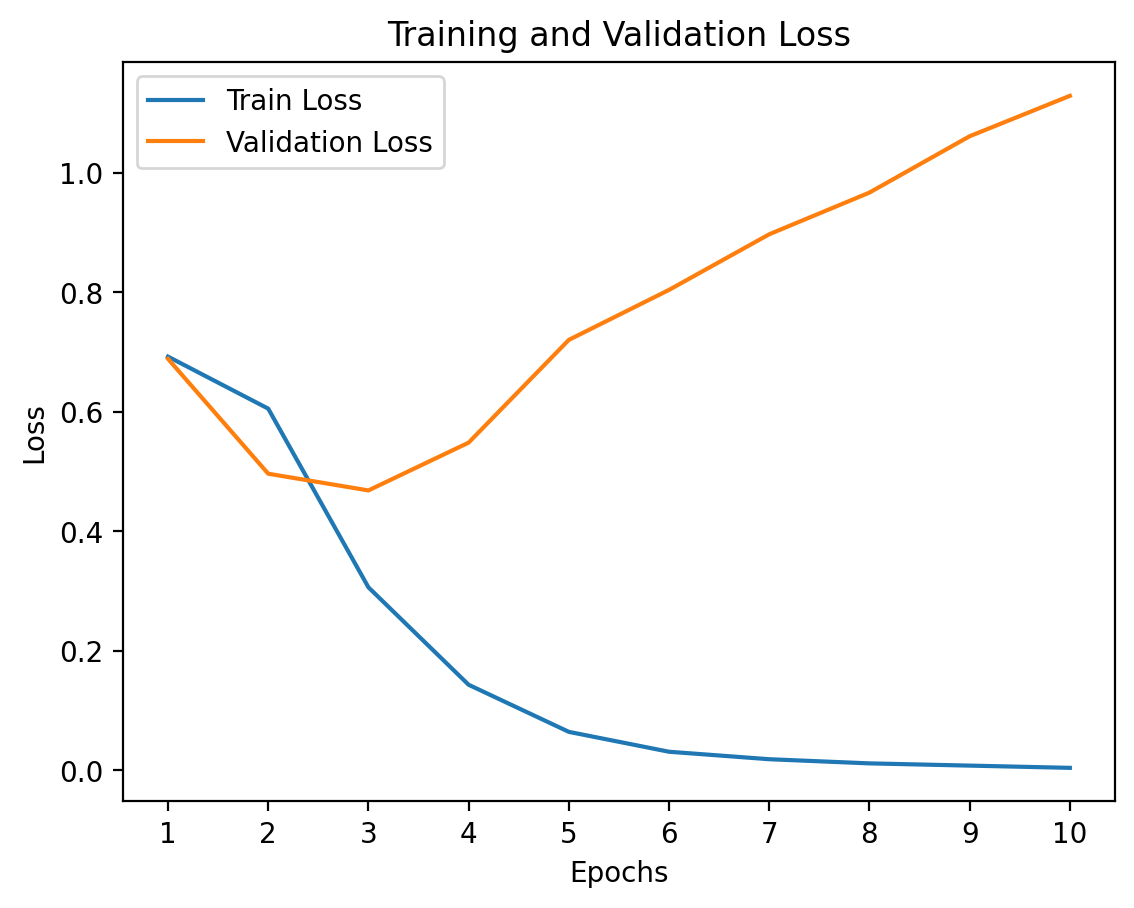

In [54]:
import torch.optim as optim

bow_model = MLP_Model(input_size=10000)
bow_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model.parameters(), lr=1e-4)

num_epochs = 10

epochs = list(range(1, num_epochs + 1))
train_loss_history, val_loss_history = train(
    bow_model,
    'models/bow_1.pt',
    optimizer,
    criterion,
    train_loader_bow,
    val_loader_bow,
    num_epochs,
    device
)

# Plot the training and validation loss history
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Testing on Dataset I

Test Loss: 1.1669
Accuracy: 0.7941


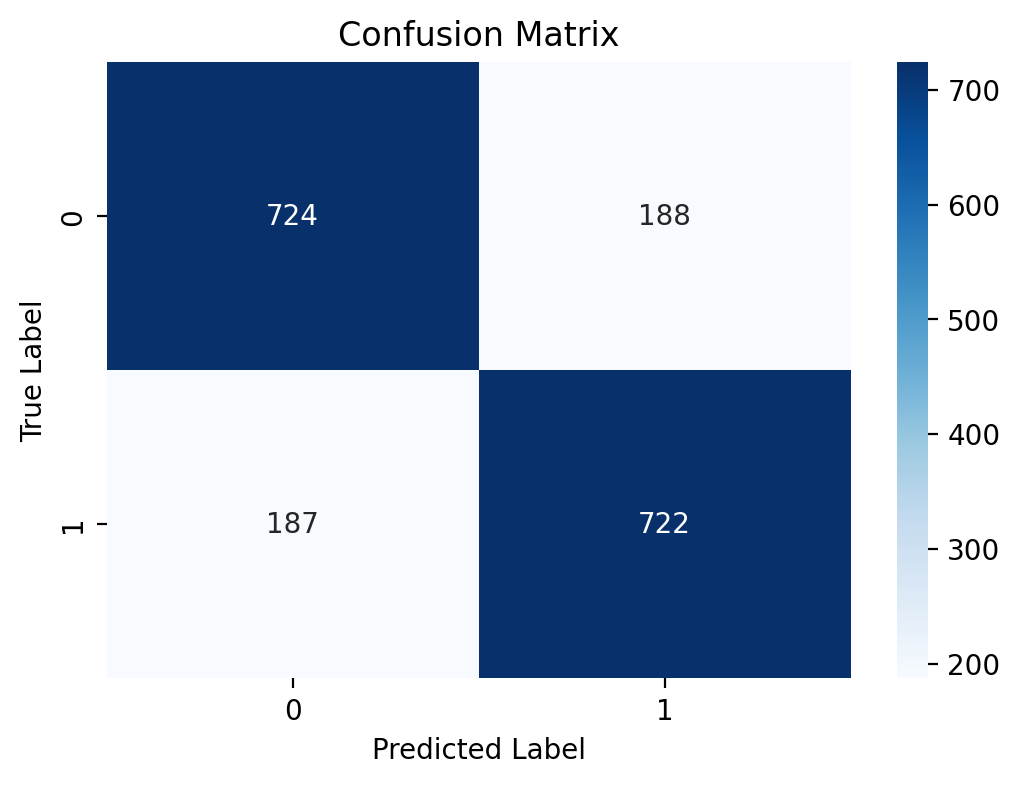

In [56]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def test(model, criterion, test_loader, device):
    model.eval()
    test_loss = 0
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            y_pred_logits = model(X_batch)  # shape: (batch_size, num_classes)
            loss = criterion(y_pred_logits, y_batch)
            test_loss += loss.item()

            # Get predicted labels
            y_pred_labels = torch.argmax(y_pred_logits, dim=1)  # Predicted class indices

            # Collect true and predicted labels for metrics
            all_y_true.extend(y_batch.cpu().numpy())
            all_y_pred.extend(y_pred_labels.cpu().numpy())

    # Average test loss over all batches
    test_loss /= len(test_loader)

    # Compute metrics
    accuracy = accuracy_score(all_y_true, all_y_pred)
    conf_matrix = confusion_matrix(all_y_true, all_y_pred)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, conf_matrix

accuracy_bow_1, conf_matrix_bow_1 = test(bow_model, criterion, test_loader_bow, device)

### Training on Dataset II

In [57]:
train_imdb_dataset = TextDataset(imdb_train_df["text"].tolist(), imdb_train_df["label"].tolist())
val_imdb_dataset = TextDataset(imdb_val_df["text"].tolist(), imdb_val_df["label"].tolist())
test_imdb_dataset = TextDataset(imdb_test_df["text"].tolist(), imdb_test_df["label"].tolist())

train_loader_bow_imdb = DataLoader(train_imdb_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bow_collate_fn)
val_loader_bow_imdb = DataLoader(val_imdb_dataset, batch_size=BATCH_SIZE,shuffle = False, collate_fn=bow_collate_fn)
test_loader_bow_imdb = DataLoader(test_imdb_dataset, batch_size=BATCH_SIZE,shuffle= False, collate_fn=bow_collate_fn)

print(f"Number of training batches: {len(train_loader_bow_imdb)}")
print(f"Number of validation batches: {len(val_loader_bow_imdb)}")
print(f"Number of test batches: {len(test_loader_bow)}")

Number of training batches: 1000
Number of validation batches: 250
Number of test batches: 57


model loaded
Epoch: 1 | Train Loss: 1.0052 | Val Loss: 0.3220 | Val Acc: 0.8676
Epoch: 2 | Train Loss: 0.2702 | Val Loss: 0.2891 | Val Acc: 0.8825
Epoch: 3 | Train Loss: 0.1931 | Val Loss: 0.2880 | Val Acc: 0.8875
Epoch: 4 | Train Loss: 0.1227 | Val Loss: 0.3559 | Val Acc: 0.8842
Epoch: 5 | Train Loss: 0.0693 | Val Loss: 0.4542 | Val Acc: 0.8790
Epoch: 6 | Train Loss: 0.0424 | Val Loss: 0.5021 | Val Acc: 0.8735
Epoch: 7 | Train Loss: 0.0317 | Val Loss: 0.5565 | Val Acc: 0.8811
Epoch: 8 | Train Loss: 0.0226 | Val Loss: 0.6019 | Val Acc: 0.8754
Epoch: 9 | Train Loss: 0.0192 | Val Loss: 0.5883 | Val Acc: 0.8879
Epoch: 10 | Train Loss: 0.0169 | Val Loss: 0.5954 | Val Acc: 0.8874
best val loss: 0.2880331205129623


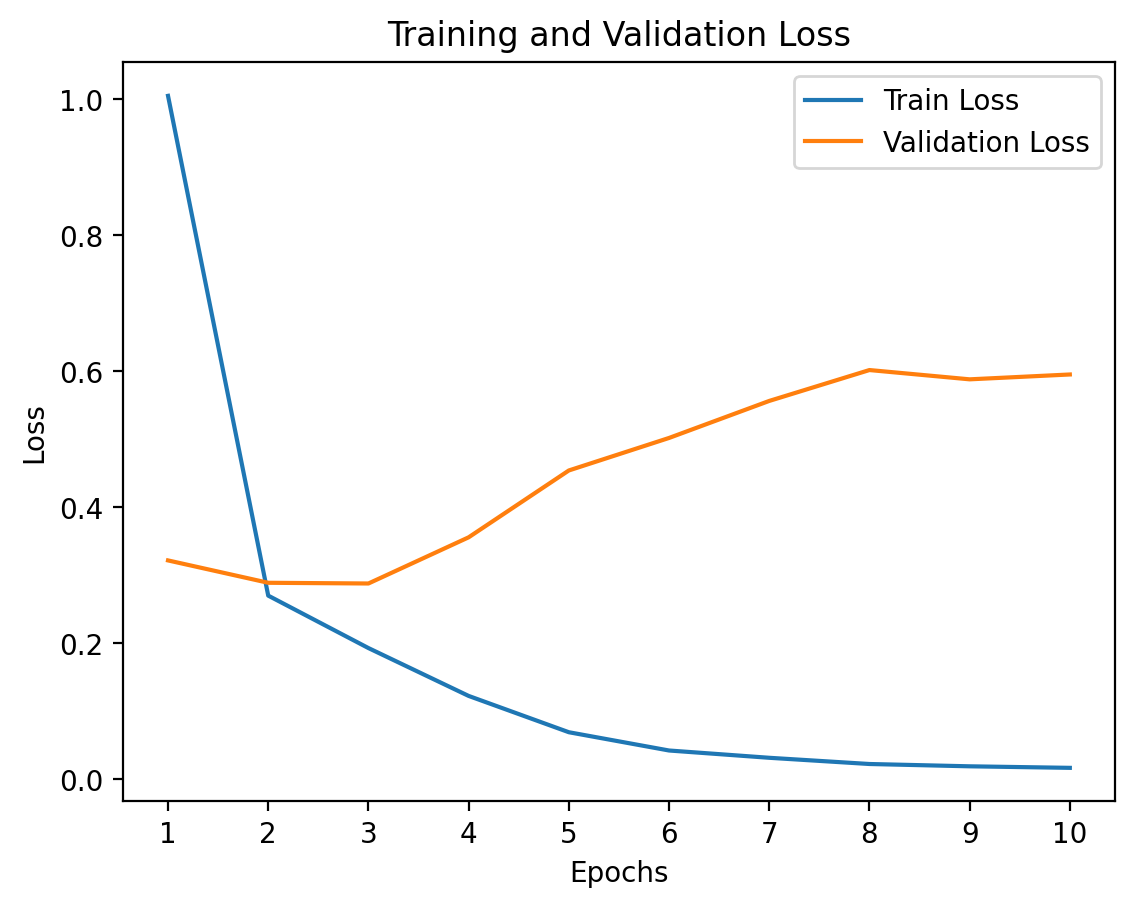

In [59]:
import torch.optim as optim 

# Load the check pointed model
bow_model_2 = MLP_Model(input_size=10000)
bow_model_2.load_state_dict(torch.load('models/bow_1.pt'))
bow_model_2.to(device)

print('model loaded')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model_2.parameters(), lr=1e-4)

num_epochs = 10

epochs = list(range(1, num_epochs + 1))
train_loss_history, val_loss_history = train(
    bow_model_2,
    'models/bow_2.pt',
    optimizer,
    criterion,
    train_loader_bow_imdb,
    val_loader_bow_imdb,
    num_epochs,
    device
)

plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Testing on Dataset II

Test Loss: 0.5957
Accuracy: 0.8844


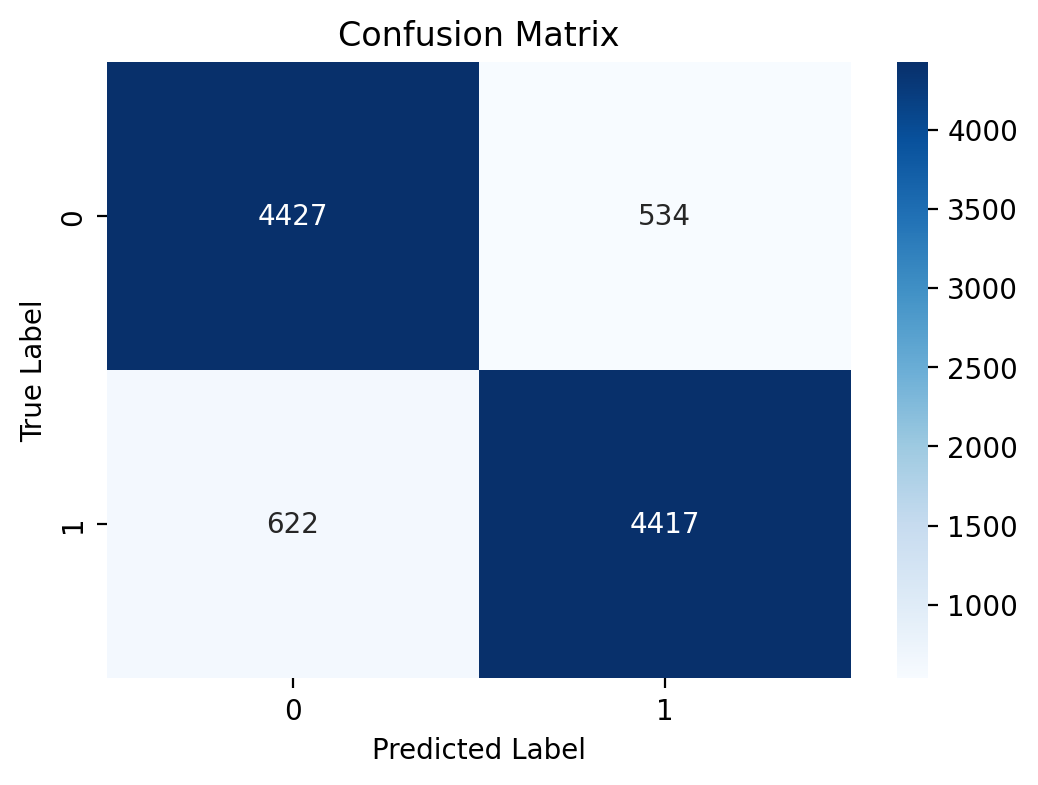

In [63]:
accuracy_bow_2, conf_matrix_bow_2 = test(bow_model_2, criterion, test_loader_bow_imdb, device)